In [1]:
import math

import tensorflow as tf
import keras_cv
from tensorflow import keras
import numpy as np

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/Users/freedom/tf-master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the Keras CV pipeline, we need the tokenizer

model = keras_cv.models.StableDiffusion(512, 512)
tokenizer = model.tokenizer

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
# most of the code is from Keras CV implementation, 
# https://github.com/keras-team/keras-cv/blob/v0.4.1/keras_cv/models/stable_diffusion/stable_diffusion.py,
# not fully implmented, just to show that converted models work

# also borrow constants from keras cv
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD

class StableDiffusionTFLite:
    MAX_PROMPT_LENGTH = 77
    img_height = 512
    img_width = 512
    
    def _get_initial_alphas(self, timesteps):
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev
    
    def _get_initial_diffusion_noise(self, batch_size, seed):
        if seed is not None:
            return tf.random.stateless_normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4),
                seed=[seed, seed],
            )
        else:
            return tf.random.normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4)
            )
        
    def _get_timestep_embedding(self, timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        freqs = tf.math.exp(
            -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    def _get_pos_ids(self):
        return tf.convert_to_tensor([list(range(self.MAX_PROMPT_LENGTH))], dtype=tf.int32)

    def encoded_token_padded(self, prompt):
        inputs = tokenizer.encode(prompt)
        phrase = inputs + [49407] * (self.MAX_PROMPT_LENGTH - len(inputs))
        phrase = tf.convert_to_tensor([phrase], dtype=tf.int32)

        return phrase, self._get_pos_ids()
    
    def encode_text(self, prompt):
        i_text_encoder = tf.lite.Interpreter('/tmp/sd_text_encoder_dynamic.tflite')
        i_text_encoder.allocate_tensors()
        input_details = i_text_encoder.get_input_details()
        output_details = i_text_encoder.get_output_details()

        token, pos = self.encoded_token_padded(prompt)
        i_text_encoder.set_tensor(input_details[0]['index'], token)
        i_text_encoder.set_tensor(input_details[1]['index'], pos)

        i_text_encoder.invoke()

        output_data = i_text_encoder.get_tensor(output_details[0]['index'])

        return output_data
    
    def encode_text_2(self, token, pos):
        i_text_encoder = tf.lite.Interpreter('/tmp/sd_text_encoder_dynamic.tflite')
        
        i_text_encoder.allocate_tensors()
        
        input_details = i_text_encoder.get_input_details()
        output_details = i_text_encoder.get_output_details()

        i_text_encoder.set_tensor(input_details[0]['index'], token)
        i_text_encoder.set_tensor(input_details[1]['index'], pos)

        i_text_encoder.invoke()

        output_data = i_text_encoder.get_tensor(output_details[0]['index'])

        return output_data


    def _expand_tensor(self, text_embedding, batch_size):
        """Extends a tensor by repeating it to fit the shape of the given batch size."""
        text_embedding = tf.squeeze(text_embedding)
        if text_embedding.shape.rank == 2:
            text_embedding = tf.repeat(
                tf.expand_dims(text_embedding, axis=0), batch_size, axis=0
            )
        return text_embedding
    
    def _get_unconditional_context(self):
        unconditional_tokens = tf.convert_to_tensor(
            [_UNCONDITIONAL_TOKENS], dtype=tf.int32
        )
        unconditional_context = self.encode_text_2(unconditional_tokens, self._get_pos_ids())
        return unconditional_context
    
    def diffusion_model(self, latent, t_emb, unconditional_context):
        i_diffusion = tf.lite.Interpreter('/tmp/sd_diffusion_model_dynamic.tflite')

        i_diffusion_input_details = i_diffusion.get_input_details()
        i_diffusion_output_details = i_diffusion.get_output_details()
        
        i_diffusion.resize_tensor_input(i_diffusion_input_details[0]['index'], latent.shape)
        i_diffusion.resize_tensor_input(i_diffusion_input_details[1]['index'], t_emb.shape)
        i_diffusion.resize_tensor_input(i_diffusion_input_details[2]['index'], unconditional_context.shape)

        i_diffusion.allocate_tensors()

        i_diffusion.set_tensor(i_diffusion_input_details[0]['index'], latent)
        i_diffusion.set_tensor(i_diffusion_input_details[1]['index'], t_emb)
        i_diffusion.set_tensor(i_diffusion_input_details[2]['index'], unconditional_context)

        i_diffusion.invoke()
        
        output_data = i_diffusion.get_tensor(i_diffusion_output_details[0]['index'])
        
        return output_data
    
    def decode(self, encoded_image):
        i_decoder = tf.lite.Interpreter('/tmp/sd_decoder_dynamic.tflite')
        
        input_details = i_decoder.get_input_details()
        output_details = i_decoder.get_output_details()
        
        i_decoder.resize_tensor_input(input_details[0]['index'], encoded_image.shape)
        
        i_decoder.allocate_tensors()
        
        i_decoder.set_tensor(input_details[0]['index'], encoded_image)
        i_decoder.invoke()
        output_data = i_decoder.get_tensor(output_details[0]['index'])

        return output_data

    def generate_image(
        self,
        encoded_text,
        negative_prompt=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt is None:
            unconditional_context = tf.repeat(
                self._get_unconditional_context(), batch_size, axis=0
            )
        else:
            unconditional_context = self.encode_text(negative_prompt)
            unconditional_context = self._expand_tensor(
                unconditional_context, batch_size
            )
        if diffusion_noise is not None:
            diffusion_noise = tf.squeeze(diffusion_noise)
            if diffusion_noise.shape.rank == 3:
                diffusion_noise = tf.repeat(
                    tf.expand_dims(diffusion_noise, axis=0), batch_size, axis=0
                )
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)

        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)
            unconditional_latent = self.diffusion_model(latent, t_emb, unconditional_context)
            
            latent = self.diffusion_model(latent, t_emb, context)
            latent = unconditional_latent + unconditional_guidance_scale * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
            latent = latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
            iteration += 1
            progbar.update(iteration)

        # Decoding stage
        decoded = self.decode(latent)
        decoded = ((decoded + 1) / 2) * 255
        return np.clip(decoded, 0, 255).astype("uint8")

In [4]:
model_t = StableDiffusionTFLite()

In [5]:
encoded_text_tflite = model_t.encode_text('a photo of an astronaut riding a horse on Mars')
f = model_t.generate_image(encoded_text_tflite, num_steps=25, batch_size=2)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Metal device set to: Apple M1
25/25 [==============================] - 2221s 90s/step


In [6]:
from PIL import Image

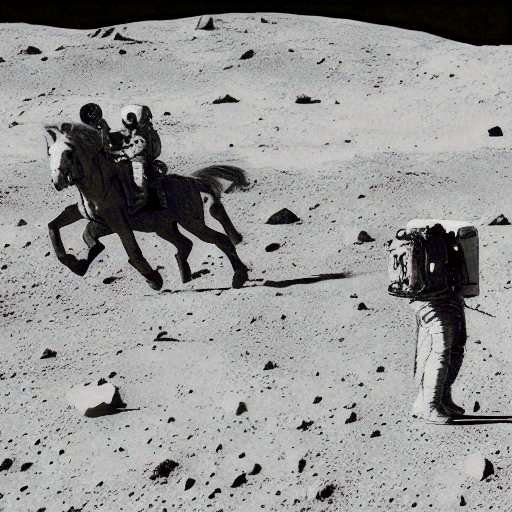

In [7]:
Image.fromarray(tf.squeeze(f[0]).numpy())

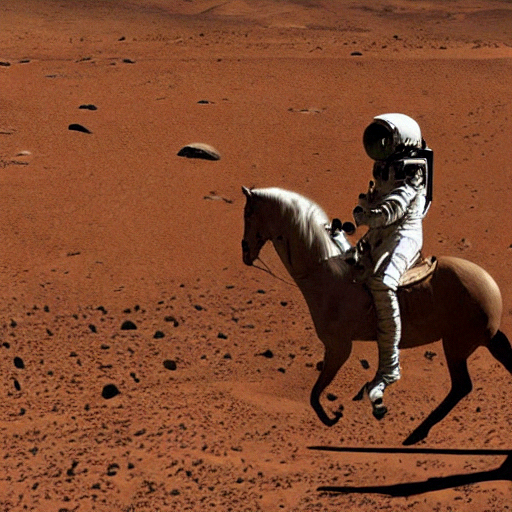

In [8]:
Image.fromarray(tf.squeeze(f[1]).numpy())